In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import scipy
import seaborn as sns

In [2]:
business_data = pd.read_csv("Resources/yelp_business.csv")
business_hours_data = pd.read_csv("Resources/yelp_business_hours.csv")
check_in_data = pd.read_csv("Resources/yelp_checkin.csv")
review_data  = pd.read_csv("Resources/yelp_review.csv")
business_attributes_data = pd.read_csv("Resources/yelp_business_attributes.csv")
tip_data = pd.read_csv("Resources/yelp_tip.csv")
user_data = pd.read_csv("Resources/yelp_user.csv")

In [6]:
#null values
business_data.isnull().sum().sort_values(ascending = False)

neighborhood    106552
postal_code        623
longitude            1
latitude             1
state                1
city                 1
categories           0
is_open              0
review_count         0
stars                0
address              0
name                 0
business_id          0
dtype: int64

In [7]:
business_data.city.value_counts()

Las Vegas                       26775
Phoenix                         17213
Toronto                         17206
Charlotte                        8553
Scottsdale                       8228
Pittsburgh                       6355
Mesa                             5760
Montréal                         5709
Henderson                        4465
Tempe                            4263
Chandler                         3994
Edinburgh                        3868
Cleveland                        3322
Madison                          3213
Glendale                         3206
Gilbert                          3128
Mississauga                      2726
Stuttgart                        2000
Peoria                           1706
Markham                          1564
North Las Vegas                  1393
Champaign                        1195
Scarborough                      1095
North York                       1092
Surprise                         1018
Richmond Hill                     888
Concord     

In [12]:
# top 10 most reviewed business
business_data[['name','review_count','city','stars']].sort_values(ascending = False,by='review_count')[0:10]

,name,review_count,city,stars
97944,"""Mon Ami Gabi""",7361,Las Vegas,4.0
119907,"""Bacchanal Buffet""",7009,Las Vegas,4.0
69993,"""Wicked Spoon""",5950,Las Vegas,3.5
81212,"""Gordon Ramsay BurGR""",5447,Las Vegas,4.0
139699,"""Earl of Sandwich""",4869,Las Vegas,4.5
19191,"""Hash House A Go Go""",4774,Las Vegas,4.0
80590,"""The Buffet""",4018,Las Vegas,3.5
124412,"""Lotus of Siam""",3964,Las Vegas,4.0
21006,"""Serendipity 3""",3910,Las Vegas,3.0
93038,"""The Buffet at Bellagio""",3838,Las Vegas,3.5


Text(0.5,1,'Top 20 Cities by Businesses Listed')

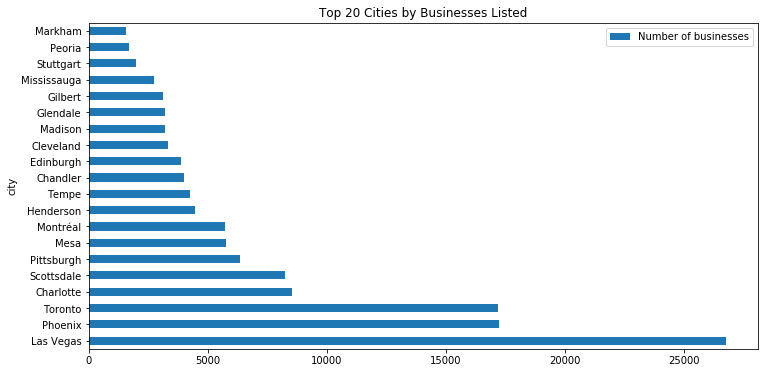

In [26]:
# No. of business in different cities
city_business_counts = business_data[['city', 'business_id']].groupby(['city'])\
['business_id'].agg('count').sort_values(ascending=False)
city_business_counts = pd.DataFrame(data = city_business_counts)
city_business_counts.rename(columns={'business_id' : 'Number of businesses'}, inplace=True)

city_business_counts[0:20].sort_values(ascending=False, by="Number of businesses")\
.plot(kind='barh', stacked=False, figsize=[12,6])
plt.title('Top 20 Cities by Businesses Listed')

In [28]:
#Cities with most reviews and average ratings
city_business_reviews = business_data[['city', 'review_count', 'stars']].groupby(['city']).\
agg({'review_count': 'sum', 'stars': 'mean'}).sort_values(by='review_count', ascending=False)
city_business_reviews.head(10)

,review_count,stars
city,,
Las Vegas,1604173,3.709916
Phoenix,576709,3.673793
Toronto,430923,3.487272
Scottsdale,308529,3.948529
Charlotte,237115,3.571554
Pittsburgh,179471,3.629819
Henderson,166884,3.789362
Tempe,162772,3.729885
Mesa,130883,3.636024


Text(0.5,1,'Cities with greater than 100k reviews ranked by stars')

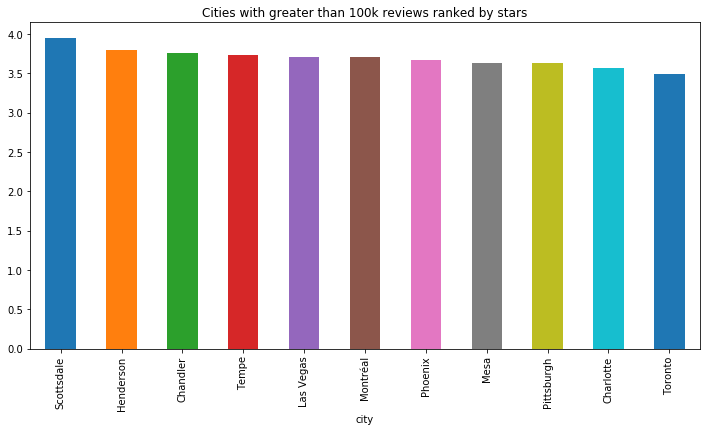

In [29]:
city_business_reviews[city_business_reviews.review_count > 100000]['stars'].sort_values(ascending =False)\
.plot(kind='bar', stacked=False, figsize=[12,6])
plt.title('Cities with greater than 100k reviews ranked by stars')

In [30]:
#business_data_to_load = "dataset/yelp_business.csv"
yelp_business_df = pd.read_csv(business_data)
yelp_business_df.head()

ValueError: Invalid file path or buffer object type: <class 'pandas.core.frame.DataFrame'>

In [ ]:
yelp_business_df.drop(['business_id','neighborhood','latitude','longitude','is_open'], axis = 1, inplace = True)
yelp_business_df.head()

In [ ]:
plt.figure(figsize=(12,4))
ax = sns.countplot(yelp_business_df['stars'])
plt.title('Distribution of Ratings');

In [ ]:
business_cats=';'.join(yelp_business_df['categories'])
cats=pd.DataFrame(business_cats.split(';'),columns=['category'])
cats_ser = cats.category.value_counts()

cats_df = pd.DataFrame(cats_ser)
cats_df.reset_index(inplace=True)

plt.figure(figsize=(12,10))
f = sns.barplot( y= 'index',x = 'category' , data = cats_df.iloc[0:20])
f.set_ylabel('Category')
f.set_xlabel('Number of businesses'); 